# Hard EM - VAE: Fashion MNIST

In this notebook, we test the effectiveness and speed of hard-EM applied to a factor analysis and homoskedastic encoder.

We test this notebook considering an adam optimiser for both the VAE and the E and M steps of DLM hard EM.

# Fitting a distribution $q_n$ given $\boldsymbol\theta$

In this section, we find a variational distribution $q_n$ for $\boldsymbol\theta_\text{vae}$ and $\boldsymbol\theta_\text{hard-em}$. We consider a dataset ${\bf X}_\text{test}$ and train an unamortised variational distribution of the form

$$
    q_n(z_n) = \mathcal{N}(z_n \vert \mu_n, \sigma_n)
$$

In [1]:
import os

os.environ["TPU_CHIPS_PER_HOST_BOUNDS"] = "1,1,1"
os.environ["TPU_HOST_BOUNDS"] = "1,1,1"
os.environ["TPU_VISIBLE_DEVICES"] = "0"

In [2]:
import jax
import json
import glob
import tomli
import pickle
import flax.linen as nn
import numpy as np
import pandas as pd
import jax.numpy as jnp
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
%config InlineBackend.figure_format = "retina"

In [4]:
import sys
sys.path.append("../experiments/")
import base_vae_hardem

In [5]:
def build_iwmll_df(output):
    dict_mll_epochs = output["test"]
    df_all = []
    for key in dict_mll_epochs:
        df_mll = pd.DataFrame.from_dict(dict_mll_epochs[key])
        df_mll.columns = ["hard-em", "vae"]
        df_mll = pd.DataFrame.from_dict(dict_mll_epochs[key])
        df_mll.columns = [f"hard-em", "vae"]
        df_mll = df_mll.melt(value_name="mll")
        df_mll["episode"] = int(key.lstrip("e"))
        df_all.append(df_mll)
    df_all = pd.concat(df_all, axis=0)
    return df_all

## Load base configuration

In [6]:
path_config = "../experiments/configs/fmnistv02.toml"
with open(path_config, "rb") as f:
    config_str = f.read().decode("utf-8")
    config = tomli.loads(config_str)

print(config_str)

# TOML file for a fashion mnist dataset
[setup]
dim_latent = 50

[warmup]
    num_obs = 10000
    num_epochs = 1000
    batch_size = 200
    eval_epochs = [2, 10, 100, 250, 500, 1000]
    learning_rate = 1e-6 # For VAE and HardEM

    [warmup.vae]
        num_is_samples = 10
    [warmup.hard_em]
        num_its_latent = 20 # E-step
        num_its_params = 5 # M-step

[test]
    num_obs = 1000
    num_epochs = 1000
    learning_rate = 1e-6
    num_is_samples = 10


In [7]:
from typing import List, Tuple

In [8]:
class ConvEncoder(nn.Module):
    latent_dim: Tuple

    @nn.compact
    def __call__(self, x):
        z = nn.Conv(5, (3, 3), padding="SAME")(x)
        z = nn.elu(z)
        z = nn.max_pool(z, (2, 2), padding="SAME")
        z = z.reshape((z.shape[0], -1))
        z = nn.Dense(self.latent_dim)(z)

        mean_z = nn.Dense(self.latent_dim)(z)
        logvar_z = nn.Dense(self.latent_dim)(z)
        return mean_z, logvar_z


class ConvDecoder(nn.Module):
    dim_obs: List
    dim_latent: int

    @nn.compact
    def __call__(self, z):
        x = nn.Dense(28 ** 2)(z)
        x = x.reshape(*z.shape[:-1], *(28, 28, 1))
        x = nn.elu(x)
        x = nn.Conv(5, (3, 3), padding="SAME")(x)
        x = nn.elu(x)
        x = nn.Conv(1, (3, 3), padding="SAME")(x)
        return x

# Learning rates

In [9]:
import hlax

In [15]:
num_warmup = config["warmup"]["num_obs"]
num_test = config["test"]["num_obs"]
warmup, test = hlax.datasets.load_fashion_mnist(num_warmup, num_test, melt=False)
X_warmup, X_test = warmup[0], test[0]
# Add number of input channels: 1
X_warmup = X_warmup[..., None]
X_test = X_test[..., None]

## Iteration - 01

In [16]:
key = jax.random.PRNGKey(314)
lossfn_vae = hlax.losses.iwae_bern
lossfn_hardem = hlax.losses.hard_nmll_bern

grad_neg_iwmll_encoder = jax.value_and_grad(hlax.losses.neg_iwmll_bern, argnums=1)
vmap_neg_iwmll = jax.vmap(hlax.losses.neg_iwmll_bern, (0, 0, None, 0, None, None, None))

In [17]:
_, *dim_obs = X_warmup.shape
dim_latent = config["setup"]["dim_latent"]
model_vae = hlax.models.VAEBern(dim_latent, dim_obs, ConvEncoder, ConvDecoder)
model_decoder = ConvDecoder(1, dim_latent)
model_encoder_test = hlax.models.GaussEncoder(dim_latent)

In [18]:
output = base_vae_hardem.main(
    key,
    X_warmup,
    X_test,
    config,
    model_vae,
    model_decoder,
    model_encoder_test,
    lossfn_vae,
    lossfn_hardem,
    grad_neg_iwmll_encoder,
    vmap_neg_iwmll,
)

Warmup phase


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Test phase


  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

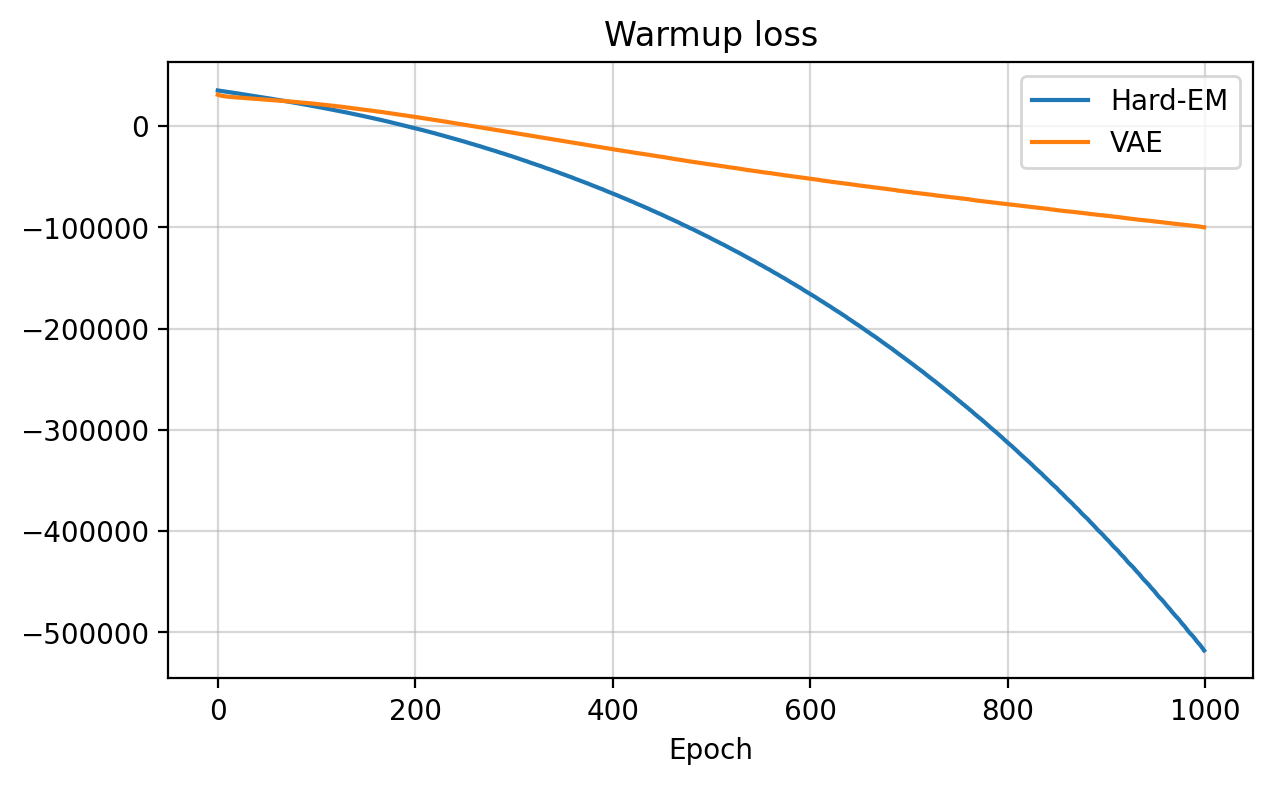

In [21]:
fig, ax = plt.subplots(figsize=(7, 4))
plt.plot(output["warmup"]["hardem"]["hist_loss"], label="Hard-EM")
plt.plot(output["warmup"]["vae"]["hist_loss"], label="VAE")
plt.legend()
plt.title("Warmup loss")
plt.xlabel("Epoch")
plt.grid(alpha=0.5)

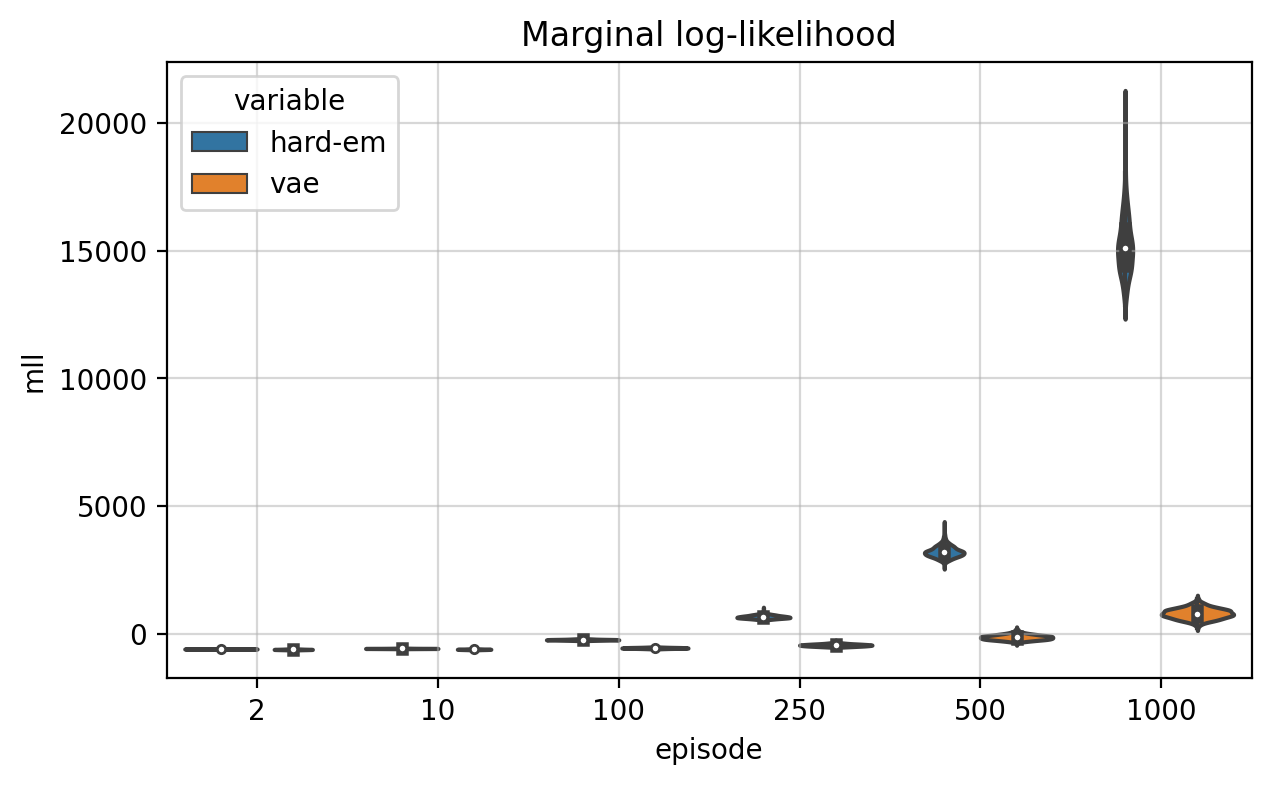

In [24]:
fig, ax = plt.subplots(figsize=(7, 4))
df_all = build_iwmll_df(output)
sns.violinplot(x="episode", y="mll", hue="variable", data=df_all)
plt.title("Marginal log-likelihood")
plt.grid(alpha=0.5)

## Iteration - 02

In [142]:
config_mod = dict(config)
config_mod["warmup"]["num_epochs"] = 3000
config_mod["warmup"]["learning_rate"] = 1e-6

eval_epochs = [2, 10, 100, 250, 500, 1000, 1250, 1500, 2000, 2250, 2500, 3000, 3250, 3500, 4000]
config_mod["warmup"]["eval_epochs"] = eval_epochs

config_mod["warmup"]["hard_em"]["num_its_latent"] = 5

In [ ]:
output = base_vae_hardem.main(config_mod, dict_models)

fig, ax = plt.subplots(figsize=(8, 3))
plt.plot(output["warmup"]["vae"]["hist_loss"])
plt.plot(output["warmup"]["hardem"]["hist_loss"])
plt.legend()
ax.grid(alpha=0.5)

### IWMLL

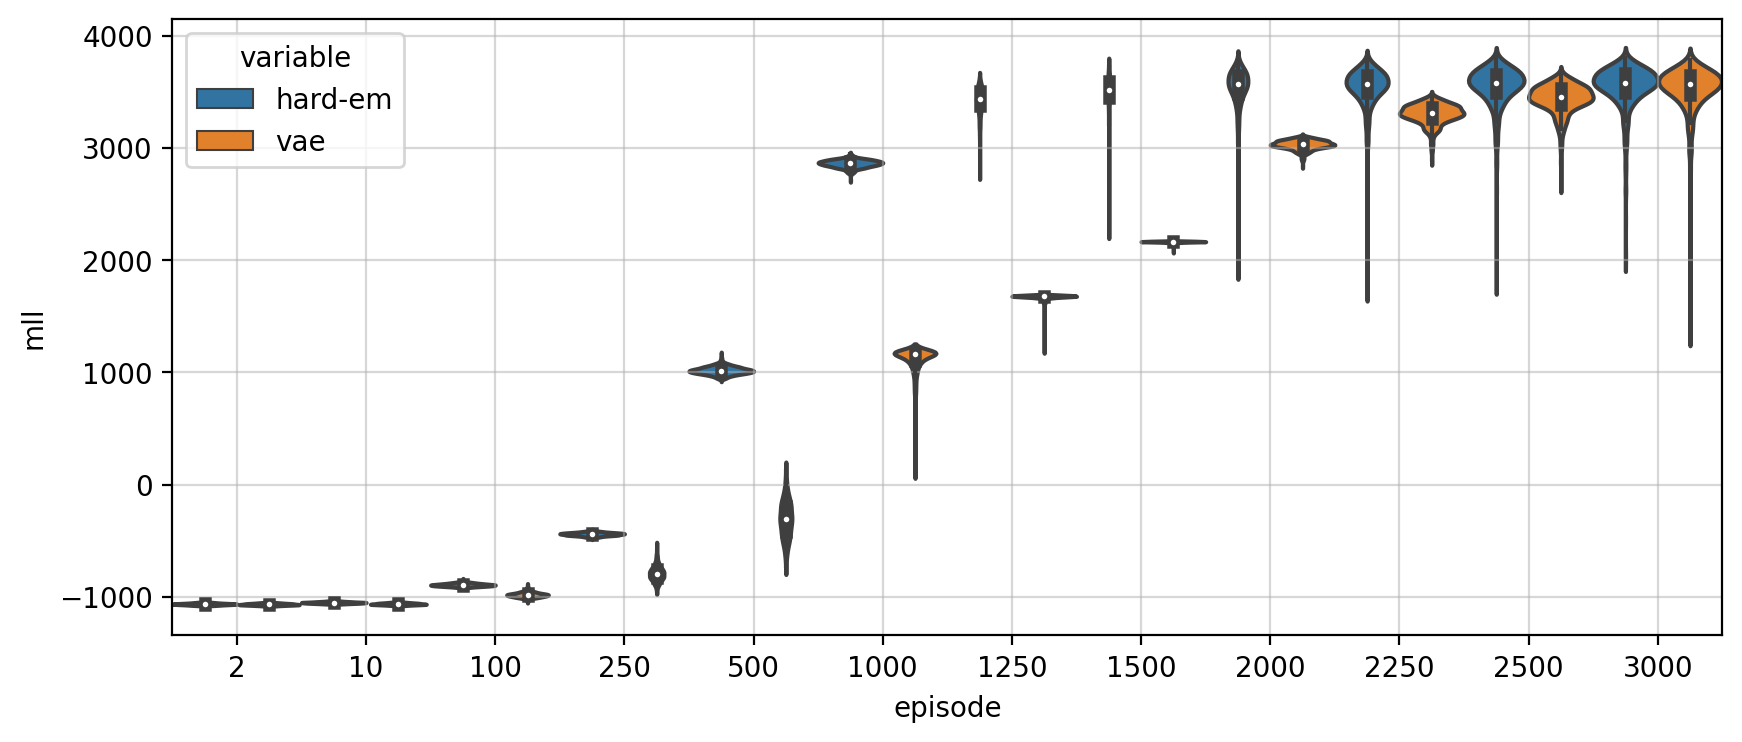

In [144]:
df_all = build_iwmll_df(output)
fig, ax = plt.subplots(figsize=(10, 4))
sns.violinplot(x="episode", y="mll", hue="variable", data=df_all, ax=ax, width=1.0)
plt.grid(alpha=0.5)

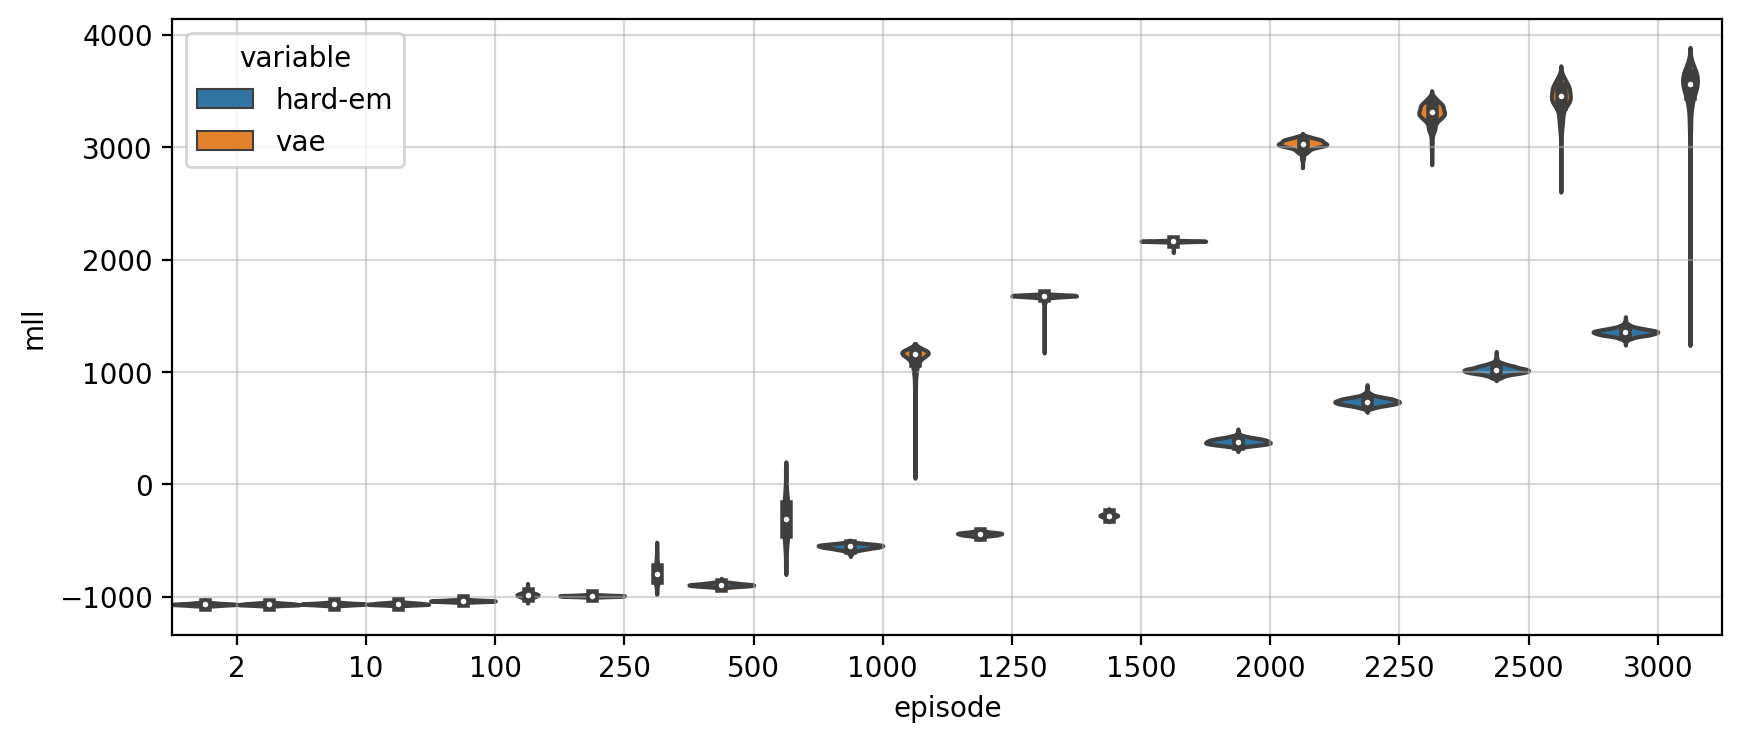

In [148]:
df_all = build_iwmll_df(output)
fig, ax = plt.subplots(figsize=(10, 4))
sns.violinplot(x="episode", y="mll", hue="variable", data=df_all, ax=ax, width=1.0)
plt.grid(alpha=0.5)

## Iteration - 03

In [25]:
from itertools import product

In [26]:
vals_latent = [1, 2, 3, 5, 10]
vals_params = [1, 2, 3, 5, 10]

config_mod = dict(config)
config_mod["warmup"]["num_epochs"] = 3000
config_mod["warmup"]["learning_rate"] = 1e-6

eval_epochs = [2, 10, 100, 250, 500, 1000, 1250, 1500, 2000, 2250, 2500, 3000]
config_mod["warmup"]["eval_epochs"] = eval_epochs

In [28]:
%%time
df_configs = []
    
for vlatent, vparam in product(vals_latent, vals_params):
    print(f"Evaluating {vlatent=} | {vparam=}")

    config_mod["warmup"]["hard_em"]["num_its_latent"] = vlatent
    config_mod["warmup"]["hard_em"]["num_its_params"] = vparam
    
    output = base_vae_hardem.main(
        key,
        X_warmup,
        X_test,
        config,
        model_vae,
        model_decoder,
        model_encoder_test,
        lossfn_vae,
        lossfn_hardem,
        grad_neg_iwmll_encoder,
        vmap_neg_iwmll,
    )
    
    df_all = build_iwmll_df(output)
    df_all["it_params"] = vparam
    df_all["it_latent"] = vlatent
    
    df_configs.append(df_all)

Evaluating vlatent=1 | vparam=1
Warmup phase


  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

Test phase


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Evaluating vlatent=1 | vparam=2
Warmup phase


  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

Test phase


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Evaluating vlatent=1 | vparam=3
Warmup phase


  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

Test phase


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Evaluating vlatent=1 | vparam=5
Warmup phase


  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

Test phase


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Evaluating vlatent=1 | vparam=10
Warmup phase


  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

Test phase


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Evaluating vlatent=2 | vparam=1
Warmup phase


  0%|          | 0/3000 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [29]:
df_configsc = pd.concat(df_configs, axis=0)

df_configsc = pd.concat([
    df_configsc.query("variable != 'vae'"),
    df_configsc.query("(variable == 'vae') & (it_params == 1) & (it_latent == 5)"),
], axis=0)


df_configsc = df_configsc.assign(variable=df_configsc["variable"] + df_configsc["it_params"].astype(str))

In [30]:
df_configsc.query("variable != 'vae'").pivot_table(index="it_params", columns="it_latent", values="mll")

it_latent,1
it_params,
1,1009.742249
2,5605.600098
3,15401.106445
5,61094.355469
10,461770.937500


In [33]:
df_configsc.query("it_latent == 1 & episode >= 100")

,variable,mll,episode,it_params,it_latent
0,hard-em1,-5.439415e+02,100,1,1
1,hard-em1,-5.543659e+02,100,1,1
2,hard-em1,-5.551937e+02,100,1,1
3,hard-em1,-5.357320e+02,100,1,1
4,hard-em1,-5.502012e+02,100,1,1
...,...,...,...,...,...
995,hard-em10,1.736752e+06,3000,10,1
996,hard-em10,1.925354e+06,3000,10,1
997,hard-em10,2.131264e+06,3000,10,1
998,hard-em10,2.223578e+06,3000,10,1


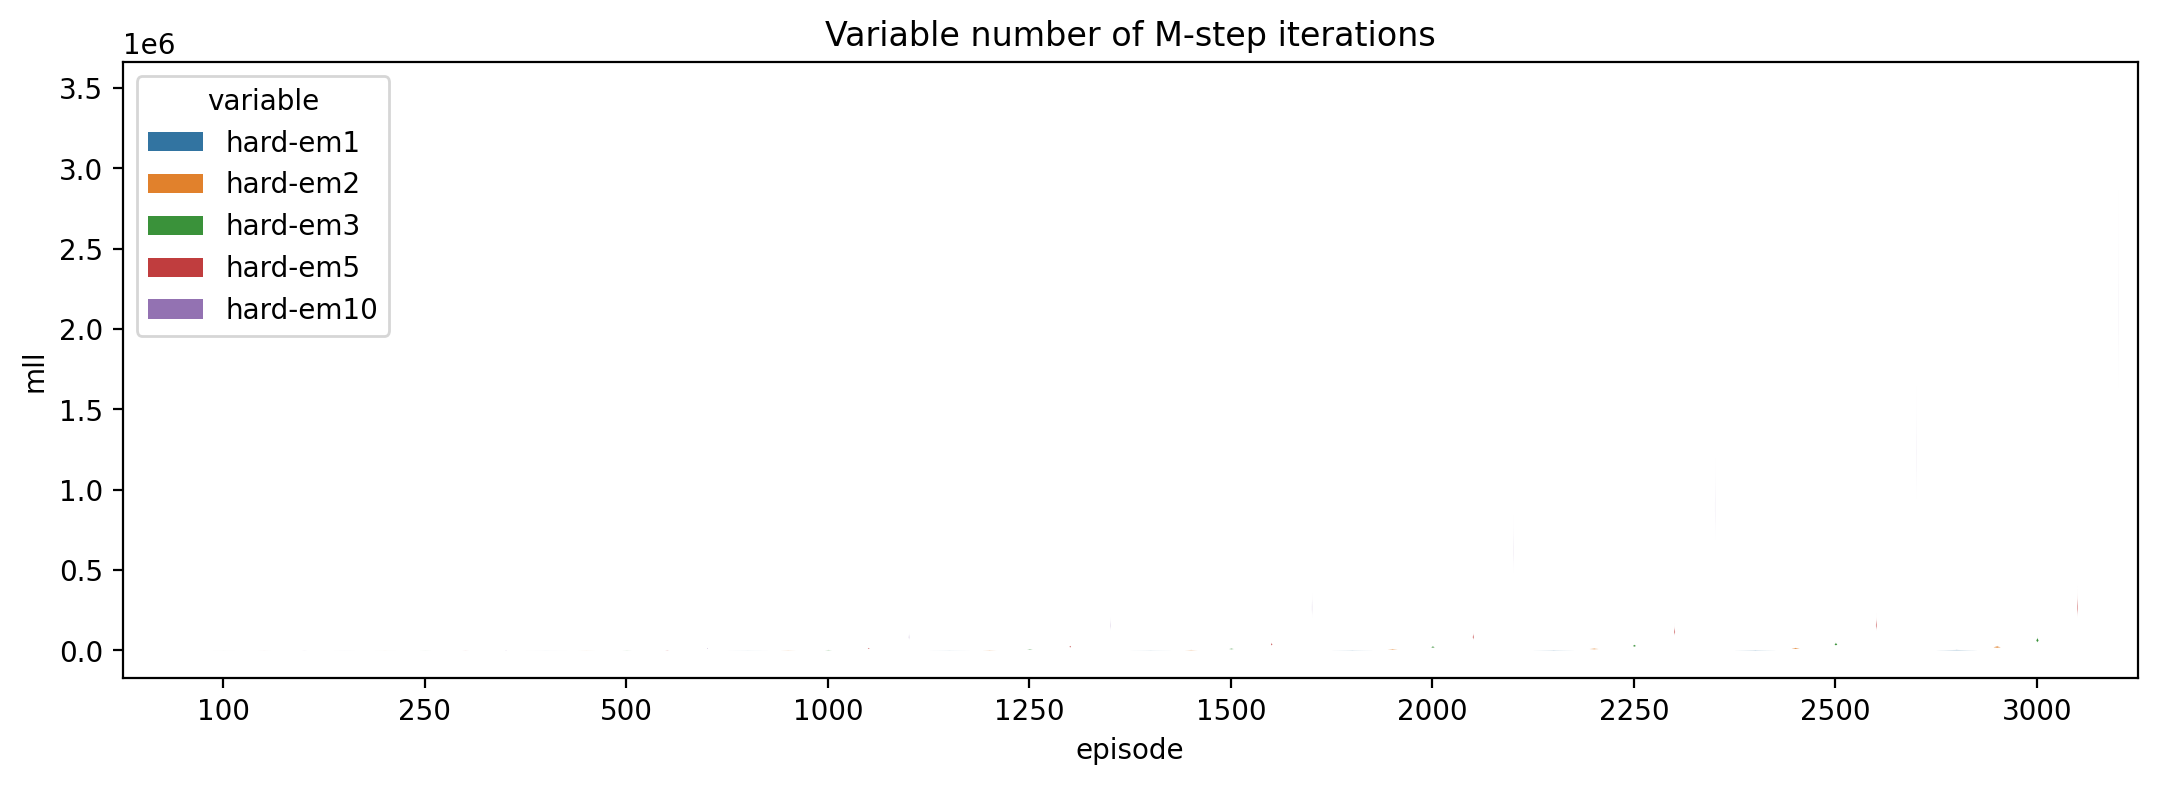

In [34]:
fig, ax = plt.subplots(figsize=(13, 4))
sns.violinplot(
    x="episode", y="mll", hue="variable", 
    data=df_configsc.query("it_latent == 1 & episode >= 100"),
)
plt.title("Variable number of M-step iterations");

In [ ]:
output = base_vae_hardem.main(config_mod, dict_models)

fig, ax = plt.subplots( figsize=(6.4, 3) )
plt.plot(output["warmup"]["vae"]["hist_loss"], label="VAE")
plt.plot(output["warmup"]["hardem"]["hist_loss"], label="Hard EM")
plt.legend()
ax.grid(alpha=0.5)

### IWMLL